# Run these three cells first:

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib import readbst
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from pyproj import Proj, transform
from pygplib3 import landfall as ld
from wind_reconstruct.w_profile_2 import W_profile # from Qidong
from wind_reconstruct.w_profile import W_profile as W_profile_old # from Qidong
import math
import multiprocessing
from joblib import Parallel, delayed

In [3]:
# Bounding box for the Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

# Indices of bounding box for Philippines
#buffer = 15 # additional space around the Philippines, in indices of the land mask
#lonmini = np.argmin(np.abs(llon-lonmin))-buffer
#lonmaxi = np.argmin(np.abs(llon-lonmax))+buffer
#latmini = np.argmin(np.abs(llat-latmin))+buffer
#latmaxi = np.argmin(np.abs(llat-latmax))-buffer

# Create land mask for just the Philippines
#ldmask_phi = np.zeros(np.shape(ldmask))
#ldmask_phi[latmaxi:latmini+1,lonmini:lonmaxi+1] = ldmask[latmaxi:latmini+1,lonmini:lonmaxi+1]

# Initial subsetting of landfalling TCs over Philippines:

In [4]:
# Load data from file
fileName = '/data2/clee/bttracks/Allstorms.ibtracs_all.v03r10.nc'
ibtracs = readbst.read_ibtracs(fileName, 'wnp')
lon = ibtracs.lon[:]
lat = ibtracs.lat[:]
wspd = ibtracs.wspd[:] # wind speed in knots
days = ibtracs.days[:] # date in days
dist2land = ibtracs.dist2land[:]
year = ibtracs.year[:]

# Load land-sea mask
llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')
land = np.max(ldmask)
ocean = np.min(ldmask)

[10] wnp
(2071,)


/home/jbaldwin/lib/python/pygplib/readbst.py:174: RuntimeWarning: invalid value encountered in less
  lon[lon < 0] = lon[lon < 0]+360
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [5]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon_int = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat_int = ld.rescale_matrix(lat,nscale,0)
wspd_int = ld.rescale_matrix(wspd,nscale,0)
days_int = ld.rescale_matrix(days,nscale,0)

In [6]:
# Retrieve times of landfall for the WNP
iSlandfall = ld.get_landfall_stormID(lon_int,lat_int,wspd_int,llon,llat,ldmask,land,np.min(ldmask))
landfall_times = ld.get_landfall_storm_time(iSlandfall,lon_int,lat_int,wspd_int,llon,llat,ldmask,land,ocean,24)
nSlandfall_first = landfall_times[0] # index of storms that make first landfall (why different than nSlandfall?)
iTlandfall_first = landfall_times[1] # time of making first landfall
nSlandfall_all = landfall_times[2] # index of storms that make any landfall (ie storm would repeat if makes multiple landfalls)
iTlandfall_all = landfall_times[3] # time of making that landfall

KeyboardInterrupt: 

In [ ]:
# Select storms making landfall in Philippines
nSlandfall_all_phi = []
iTlandfall_all_phi = []
for j in range(np.shape(nSlandfall_all)[0]):
    nS = nSlandfall_all[j]
    iT = iTlandfall_all[j]
    lon_landfall = lon_int[iT,nS]
    lat_landfall = lat_int[iT,nS]
    if lonmin <= lon_landfall <= lonmax and latmin <= lat_landfall <= latmax:
        nSlandfall_all_phi.append(nSlandfall_all[j])
        iTlandfall_all_phi.append(iTlandfall_all[j])

# Remove duplicate storms (storms that made landfall in Philippines twice)
nSlandfall_phi = list(dict.fromkeys(nSlandfall_all_phi))
    

In [ ]:
# Select data only for storms that make landfall in the Philippines
# (for normal timesteps and interpolated timestep data)
lon_phi = lon[:,nSlandfall_phi]
lat_phi = lat[:,nSlandfall_phi]
wspd_phi = wspd[:,nSlandfall_phi]
days_phi = days[:,nSlandfall_phi]
days_phi = np.where(days_phi==-99999., np.nan, days_phi)
year_phi = year[nSlandfall_phi]

lon_int_phi = lon_int[:,nSlandfall_phi]
lat_int_phi = lat_int[:,nSlandfall_phi]
wspd_int_phi = wspd_int[:,nSlandfall_phi]
days_int_phi = days_int[:,nSlandfall_phi]
days_int_phi = np.where(days_int_phi==-99999., np.nan, days_int_phi)

In [ ]:
# Save out data of Philippines landfalling TCs
ds = xr.Dataset(
    {"lon": (("iT","nS"), lon_phi),
     "lat": (("iT","nS"), lat_phi),
     "wspd": (("iT","nS"), wspd_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_phi),
     "year": (("nS"), year_phi)},
        coords={
        "iT": np.arange(np.shape(lon_phi)[0]),
        "nS": np.arange(np.shape(lon_phi)[1]),
     },
 )

ds_int = xr.Dataset(
    {"lon": (("iT","nS"), lon_int_phi),
     "lat": (("iT","nS"), lat_int_phi),
     "wspd": (("iT","nS"), wspd_int_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_int_phi),
     "year": (("nS"), year_phi)},
        coords={
        "iT": np.arange(np.shape(lon_int_phi)[0]),
        "nS": np.arange(np.shape(lon_int_phi)[1]),
     },
 )

ds.to_netcdf("ibtracs_landfall_philippines.nc", mode = 'w')
ds_int.to_netcdf("ibtracs_landfall_philippines_15min.nc", mode = 'w')

# Start from here if subset data already:

In [7]:
# Load subset data of landfalling storms over Philippines
dat = xr.open_dataset('ibtracs_landfall_philippines.nc')
lon = np.array(dat.lon)
lat = np.array(dat.lat)
wspd = np.array(dat.wspd)/1.944 #convert from kts to m/s
days = np.array(dat.days)
year = np.array(dat.year)

# Load land-sea mask
llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')
land = np.max(ldmask)
ocean = np.min(ldmask)

In [8]:
# Calculate track angle and track translation speed 
er = 6371.0  # earth's radius; km
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # longitude distance at a latitude; km
dx = londis*1000*lon_diff # meters
dy = 110.*1000*lat_diff # meters
time_diff = (days[1:, :] - days[0:-1, :])*24.*60*60 # seconds
tr = old_div(np.sqrt(dx**2+dy**2),(time_diff)) # track translation speed
trDir = np.arctan2(lat_diff, lon_diff) # track angle
# note: subtraction cuts off point at end, might need to add one final track direction and speed point if get errors later

In [9]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat = ld.rescale_matrix(lat,nscale,0)
wspd = ld.rescale_matrix(wspd,nscale,0)
days = ld.rescale_matrix(days,nscale,0)
tr = ld.rescale_matrix(tr,nscale,0)
trDir = ld.rescale_matrix(trDir,nscale,0)

In [10]:
%%time
# Retrieve times of landfall for the WNP
iSlandfall = ld.get_landfall_stormID(lon,lat,wspd,llon,llat,ldmask,land,np.min(ldmask))
landfall_times = ld.get_landfall_storm_time(iSlandfall,lon,lat,wspd,llon,llat,ldmask,land,ocean,24)
nSlandfall_first = landfall_times[0] # index of storms that make first landfall (why different than nSlandfall?)
iTlandfall_first = landfall_times[1] # time of making first landfall
nSlandfall_all = landfall_times[2] # index of storms that make any landfall (ie storm would repeat if makes multiple landfalls)
iTlandfall_all = landfall_times[3] # time of making that landfall

CPU times: user 20.9 s, sys: 2.09 ms, total: 20.9 s
Wall time: 20.9 s


In [11]:
# Find times that storms make landfall in the Philippines
nSlandfall_all_phi = []
iTlandfall_all_phi = []
for j in range(np.shape(nSlandfall_all)[0]):
    nS = nSlandfall_all[j]
    iT = iTlandfall_all[j]
    lon_landfall = lon[iT,nS]
    lat_landfall = lat[iT,nS]
    if lonmin <= lon_landfall <= lonmax and latmin <= lat_landfall <= latmax:
        nSlandfall_all_phi.append(nSlandfall_all[j])
        iTlandfall_all_phi.append(iTlandfall_all[j])

# Remove duplicate storms (storms that made landfall in Philippines twice)
nSlandfall_phi = list(dict.fromkeys(nSlandfall_all_phi))


In [12]:
# Select time of first landfall for each of the Philippines storms
iTlandfall_first_phi = []
for i in range(np.shape(lon)[1]):
    j = np.where(np.array(nSlandfall_all_phi)==i)[0][0]
    iTlandfall_first_phi.append(iTlandfall_all_phi[j])


Text(0.5, 1.0, 'The First Philippines Landfall of IBTrACS Typhoons Making Any Landfall in the Philippines')

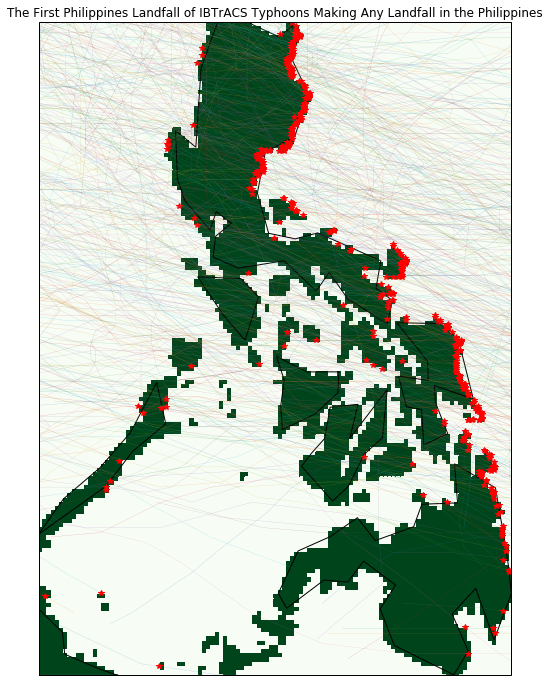

In [13]:
# Plotting tracks and landfall locations

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for n in range(np.shape(lon)[1]):
    plt.plot(lon[:,n],lat[:,n],linewidth=0.25,alpha=0.4)
    i = iTlandfall_first_phi[n]
    plt.plot(lon[i,n],lat[i,n],'*',color='r')

ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('The First Philippines Landfall of IBTrACS Typhoons Making Any Landfall in the Philippines')

Text(0.5, 1.0, 'IBTrACS Typhoons Making First Landfall in the Philippines')

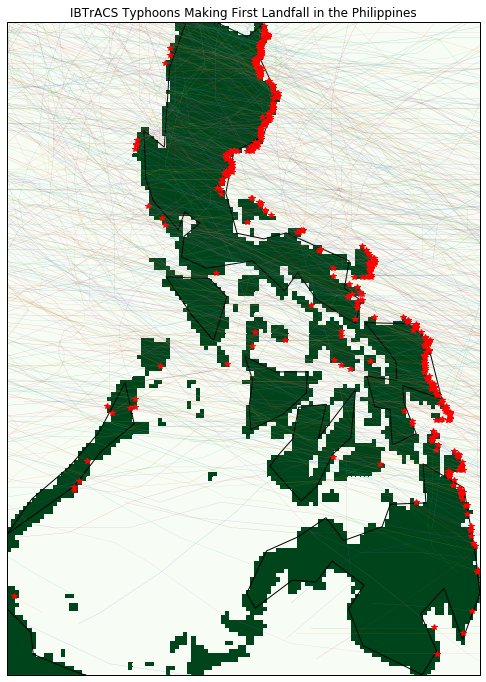

In [14]:
# Plotting tracks and first landfall locations

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for n in range(np.shape(nSlandfall_first)[0]):
    nS = nSlandfall_first[n]
    plt.plot(lon[:,nS],lat[:,nS],linewidth=0.25,alpha=0.4)
    iT = iTlandfall_first[n]
    plt.plot(lon[iT,nS],lat[iT,nS],'*',color='r')

ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('IBTrACS Typhoons Making First Landfall in the Philippines')

In [15]:
# For each storm select time points of landfall, including possibility for second landfall and potential overlap
# iTlandfall_forwindfield_phi

days_before_landfall = 1
days_post_landfall = 1
timesteps_before_landfall = days_before_landfall*4*24 # 4 15-min increments per hour, 24 hours per day
timesteps_post_landfall = days_post_landfall*4*24 # 4 15-min increments per hour, 24 hours per day

iTlandfall_forwindfield_phi = []
nSlandfall_forwindfield_phi = []
for i in range(np.shape(lon)[1]):
    nSlandfall_forwindfield_phi.append(i)
    indices_landfalls = np.where(np.array(nSlandfall_all_phi)==i)[0] # different landfalls per storm
    nlandfalls = np.shape(indices_landfalls)[0]
    if nlandfalls == 1:
        iTlandfall = iTlandfall_all_phi[indices_landfalls[0]]
        iT = np.arange(iTlandfall-timesteps_before_landfall,iTlandfall+timesteps_post_landfall+1,1)
        iTlandfall_forwindfield_phi.append(list(iT))
    if nlandfalls > 1:
        iTs = np.array([],dtype=int)
        for ii in indices_landfalls:
            iTlandfall = iTlandfall_all_phi[ii]
            iT = np.arange(iTlandfall-timesteps_before_landfall,iTlandfall+timesteps_post_landfall+1,1)
            iTs = np.concatenate((iTs,iT),axis=0)
        iTs = np.unique(iTs) # remove wind field points that repeat
        iTlandfall_forwindfield_phi.append(list(iTs))
    iTlandfall_forwindfield_phi[i] = list(filter(lambda x : x > 0, iTlandfall_forwindfield_phi[i])) # remove negative numbers from list https://www.geeksforgeeks.org/python-remove-negative-elements-in-list/ 
            

Text(0.5, 1.0, 'IBTrACS Typhoons Making Landfall in the Philippines')

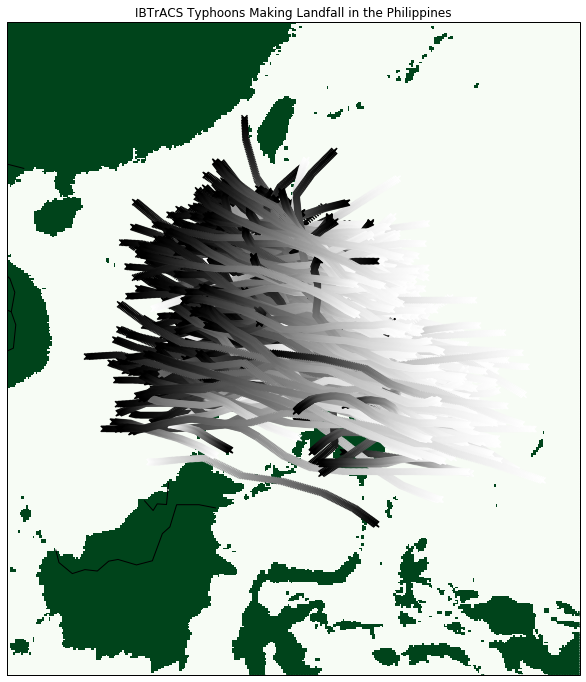

In [16]:
# Plotting tracks 1 day before and after landfall

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for nS in range(np.shape(lon)[1]):
    iT = iTlandfall_forwindfield_phi[nS]
    plt.scatter(lon[iT,nS],lat[iT,nS],marker='x',c=np.arange(0,len(lon[iT,nS]),1),cmap=plt.cm.Greys)
    #iT = iTlandfall_first[n]
    #plt.plot(lon[iT,nS],lat[iT,nS],'*',color='r')

ax.set_extent([lonmin-10,lonmax+10,latmin-10,latmax+10])
#ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('IBTrACS Typhoons Making Landfall in the Philippines')

In [17]:
# Aggregate only storm points (lat,lon,wspd) where might be making landfall
wspd_landfall = []
lon_landfall = []
lat_landfall = []
days_landfall = []
tr_landfall = []
trDir_landfall = []
year_landfall = []

for nS in range(np.shape(lon)[1]):
    iT = iTlandfall_forwindfield_phi[nS]
    wspd_landfall.append(wspd[iT,nS])
    lon_landfall.append(lon[iT,nS])
    lat_landfall.append(lat[iT,nS])
    days_landfall.append(days[iT,nS])
    tr_landfall.append(tr[iT,nS])
    trDir_landfall.append(trDir[iT,nS])

In [18]:
# Distance function
# Center of storm = lat, lon
# Calculate distance between center point and each grid point
# adopted from: https://kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python
# radius of earth in km so outputs distance in km

def distancefrompoint(lon, lat, X1, Y1):
    R = 6371.0 #radius of the Earth km

    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = np.radians(Y1)
    lon2 = np.radians(X1)

    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Set up function to run wind fields in parallel
# 32 processors total available

# Calculate wind field without adding in asymmetry
def windfield_sym(lon_nS,lat_nS,wspd_nS,rmax_nS,i):
    loni = lon_nS[i]
    lati = lat_nS[i]
    wspdi = wspd_nS[i]
    rmaxi = rmax_nS[i]
    
    # Calculate Willoughby Profile
    radius_max = 500
    radius_precision = 1
    profile = W_profile(lati, rmaxi, wspdi, radius_max, radius_precision)
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    
    # Create dict look-up table from Willoughby Profile
    wspdlookup = dict(zip(radius, profile))
    
    # Calculate distance from center of storm
    distance = distancefrompoint(loni, lati, X1, Y1) # distance in km
    
    # Round distance values to nearest whole number
    distance = distance.astype(int)

    # Remap radii to windspeed
    wspdmap = np.zeros(np.shape(distance))
    for r in radius:
        wspdmap[np.where(distance == r)] = wspdlookup[r]
        wspdmap[np.where(distance > radius_max)] = 0 # added 10-27-20
    
    return wspdmap


# Calculate wind field with asymmetry:
def windfield(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i):
    loni = lon_nS[i]
    lati = lat_nS[i]
    wspdi = wspd_nS[i]
    rmaxi = rmax_nS[i]
    tri = tr_nS[i]
    trDiri = trDir_nS[i]
    
    # Calculate tangential wind
    angle = np.arctan2((Y1-lati),(X1-loni)) - trDiri # define angle relative to track direction 
    vt = -tri*np.cos(np.pi/2 - angle) # calculate tangential wind; remove minus if southern hemisphere
    
    # Calculate Willoughby Profile
    radius_max = 500
    radius_precision = 1
    profile = W_profile(lati, rmaxi, wspdi, radius_max, radius_precision)
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    
    # Create dict look-up table from Willoughby Profile
    wspdlookup = dict(zip(radius, profile))
    
    # Calculate distance from center of storm
    distance = distancefrompoint(loni, lati, X1, Y1) # distance in km
    
    # Round distance values to nearest whole number
    distance = distance.astype(int)
    
    # Calculate rFactor to modulate track correction
    rFactor = utility.translationspeedFactor(old_div(distance,rmaxi))

    # Remap radii to windspeed
    wspdmap = np.zeros(np.shape(distance))
    for r in radius:
        wspdmap[np.where(distance == r)] = wspdlookup[r]
    
    #Add track direction correction
    wspdmap = wspdmap+(rFactor*vt)
    
    # Set to 0 outside radius_max
    wspdmap[np.where(distance > radius_max)] = 0 # added 10-27-20
    
    #wspdmaps.append(wspdmap)
    
    return wspdmap

In [19]:
%%time
# Define x-y grid to put profile on
X = np.arange(108.,138.1,0.1)#np.arange(-180,180.1,0.1)
Y = np.arange(0,25.1,0.1)
X1, Y1 = np.meshgrid(X,Y)

# Determine the max iT_lengths
iT_lengths = []
for i in np.arange(0,len(iTlandfall_forwindfield_phi),1):
    iT_lengths.append(len(iTlandfall_forwindfield_phi[i]))
iT_length_max = np.max(iT_lengths)

CPU times: user 1.71 ms, sys: 25 µs, total: 1.74 ms
Wall time: 947 µs


In [25]:
#CURRENT
missed_tries = 0
for nS in [391]: #np.arange(390,len(wspd_landfall),1):
    print(nS)
    
    # Select data for 1 storm
    notnans = ~np.isnan(wspd_landfall[nS][:]) # remove nan points from TC dissipating sooner than 1 day after first landfall
    wspd_nS = wspd_landfall[nS][notnans]
    lon_nS = lon_landfall[nS][notnans]
    lat_nS = lat_landfall[nS][notnans]
    days_nS = days_landfall[nS][notnans]
    tr_nS = tr_landfall[nS][notnans]
    trDir_nS = trDir_landfall[nS][notnans]
    
    # Calculate radius of maximum wind
    rmax_nS = utility.knaff15(wspd_nS*1.944, lat_nS)  #  wspd should be input in kts, outputs in km
    rmax_nS[np.where(rmax_nS<8)] = 8 # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
    # Calculate wind fields in parallel
    stormpoints = np.shape(wspd_nS)[0]
    #wspdmaps = np.full([1,iT_length_max,len(Y),len(X)],np.nan)
    #wspdmaps[0,0:stormpoints,:,:] = Parallel(n_jobs=16, prefer="threads")(delayed(windfield)(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
    try:
        wspdmaps = Parallel(n_jobs=16, prefer="threads")(delayed(windfield)(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
        wspdmaps = np.expand_dims(wspdmaps,axis = 0)
    
        # Days
        # days_fornc = np.full([iT_length_max],np.nan)
        # days_fornc[0:stormpoints] = days_landfall[nS][a:b]
        days_fornc = days_landfall[nS][:]
    
        # Create dataset
        ds = xr.Dataset(
         {"wspd": (("nS", "iT","lat", "lon"), wspdmaps),
          "days": (("nS","iT"), np.expand_dims(days_fornc,axis=0)),
          "year": (("nS"), [year[nS]])},
             coords={
            "nS":np.array([nS]),
            "iT":np.arange(stormpoints),
            "lat": Y,
            "lon": X,
         },
         )
    
        #Write to netcdf
        ds.to_netcdf('/data2/jbaldwin/WINDFIELDS/PHI_REG_TEST4/wspd_phi_'+str(nS)+'.nc',mode='w',unlimited_dims = ["nS"])
    except:
        missed_tries += 1

391


In [32]:
# Non loop for debugging
missed_tries = 0
nS = 391 #np.arange(390,len(wspd_landfall),1):
print(nS)
    
# Select data for 1 storm
notnans = ~np.isnan(wspd_landfall[nS][:]) # remove nan points from TC dissipating sooner than 1 day after first landfall
wspd_nS = wspd_landfall[nS][notnans]
lon_nS = lon_landfall[nS][notnans]
lat_nS = lat_landfall[nS][notnans]
days_nS = days_landfall[nS][notnans]
tr_nS = tr_landfall[nS][notnans]
trDir_nS = trDir_landfall[nS][notnans]
    
# Calculate radius of maximum wind
rmax_nS = utility.knaff15(wspd_nS*1.944, lat_nS)  #  wspd should be input in kts, outputs in km
rmax_nS[np.where(rmax_nS<8)] = 8 # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
# Calculate wind fields in parallel
stormpoints = np.shape(wspd_nS)[0]
wspdmaps = Parallel(n_jobs=16, prefer="threads")(delayed(windfield)(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
wspdmaps = np.expand_dims(wspdmaps,axis = 0)
    
# Days
days_fornc = days_landfall[nS][notnans]

# Create dataset
ds = xr.Dataset(
    {"wspd": (("nS", "iT","lat", "lon"), wspdmaps),
    "days": (("nS","iT"), np.expand_dims(days_fornc,axis=0)),
    "year": (("nS"), [year[nS]])},
        coords={
        "nS":np.array([nS]),
        "iT":np.arange(stormpoints),
        "lat": Y,
        "lon": X,
        },
        )
    
#Write to netcdf
#ds.to_netcdf('/data2/jbaldwin/WINDFIELDS/PHI_REG_TEST4/wspd_phi_'+str(nS)+'.nc',mode='w',unlimited_dims = ["nS"])


391


In [20]:
%%time

#OLD
a = 2
b = 4

for nS in [431]:#range(len(wspd_landfall)):
    
    # Select data for 1 storm
    notnans = ~np.isnan(wspd_landfall[nS][:]) # remove nan points from TC dissipating sooner than 1 day after first landfall
    wspd_nS = wspd_landfall[nS][notnans]
    lon_nS = lon_landfall[nS][notnans]
    lat_nS = lat_landfall[nS][notnans]
    days_nS = days_landfall[nS][notnans]
    tr_nS = tr_landfall[nS][notnans]
    trDir_nS = trDir_landfall[nS][notnans]
    
    # Calculate radius of maximum wind
    rmax_nS = utility.knaff15(wspd_nS*1.944, lat_nS)  #  km
    rmax_nS[np.where(rmax_nS<8)] = 8 # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
#      # Calculate wind fields in parallel
    stormpoints = np.shape(wspd_nS)[0]
     #wspdmaps = np.full([1,iT_length_max,len(Y),len(X)],np.nan)
#     #wspdmaps[0,0:stormpoints,:,:] = Parallel(n_jobs=16, prefer="threads")(delayed(windfield)(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
#    try:
#        wspdmaps = Parallel(n_jobs=16, prefer="threads")(delayed(windfield)(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
#        wspdmaps = np.expand_dims(wspdmaps,axis = 0)
    
#         # Days
#         # days_fornc = np.full([iT_length_max],np.nan)
#         # days_fornc[0:stormpoints] = days_landfall[nS][a:b]
#         days_fornc = days_landfall[nS][a:b]

#         # Create dataset
#         ds = xr.Dataset(
#          {"wspd": (("nS", "iT","lat", "lon"), wspdmaps),
#           "days": (("nS","iT"), np.expand_dims(days_fornc,axis=0)),
#           "year": (("nS"), [year[nS]])},
#              coords={
#             "nS":np.array([nS]),
#             "iT":np.arange(stormpoints),
#             "lat": Y,
#             "lon": X,
#          },
#          )

#         #Write to netcdf
#         ds.to_netcdf('wspd_phi_'+str(nS)+'.nc',mode='w',unlimited_dims = ["nS"])


CPU times: user 158 µs, sys: 0 ns, total: 158 µs
Wall time: 163 µs


In [21]:
import julian
x = julian.from_jd(days_nS[0], fmt='mjd').date()
x

datetime.date(2013, 11, 6)

In [22]:
np.argmax(wspd_nS)

61

In [23]:
i = np.argmax(wspd_nS)
asym = windfield(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i)
sym = windfield_sym(lon_nS,lat_nS,wspd_nS,rmax_nS,i)

In [24]:
np.max(wspd_nS)

87.44856262207031

Text(0.5, 0.98, 'Typhoon Haiyan, strongest time point, Vmax = 87.4')

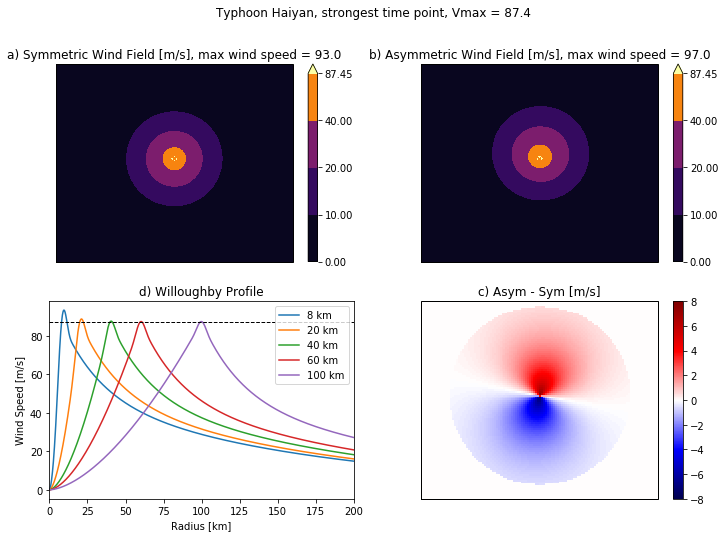

In [25]:
plt.figure(figsize=(12, 8))

x1 = 123
x2 = 135
y1 = 5
y2 = 15

ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
im = ax.contourf(X,Y,sym,cmap=plt.cm.inferno,levels=[0,10,20,40,wspd_nS[i]],extend='max')
#im = ax.pcolormesh(X,Y,sym,cmap=plt.cm.inferno,vmin=0,vmax=120)
plt.colorbar(im)
plt.title('a) Symmetric Wind Field [m/s], max wind speed = '+str(np.round(np.max(sym),decimals=1)))
ax.set_extent([x1, x2, y1, y2])

ax = plt.subplot(2,2,2,projection=ccrs.PlateCarree())
im = ax.contourf(X,Y,asym,cmap=plt.cm.inferno,levels=[0,10,20,40,wspd_nS[i]],extend='max')
plt.colorbar(im)
plt.title('b) Asymmetric Wind Field [m/s], max wind speed = '+str(np.round(np.max(asym),decimals=1)))
ax.set_extent([x1, x2, y1, y2])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
im = ax.pcolormesh(X,Y,asym-sym,cmap=plt.cm.seismic,vmin=-8,vmax=8)
plt.colorbar(im)
plt.title('c) Asym - Sym [m/s]')
ax.set_extent([x1, x2, y1, y2])

plt.subplot(2,2,3)
n = 61
lati = lat_nS[n]
rmaxi = [8,20,40,60,100]#,20,40,60,100]#rmax_nS[n]
wspdi = wspd_nS[n]
radius_max = 500
radius_precision = 0.1
for rmax in rmaxi:
    profile = W_profile(lati, rmax, wspdi, radius_max, radius_precision)
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    plt.plot(radius,profile,label=str(np.round(rmax,decimals=1))+' km')
plt.xlabel('Radius [km]')
plt.ylabel('Wind Speed [m/s]')
plt.title('d) Willoughby Profile')
plt.legend()
plt.axhline(wspdi,linewidth=1,linestyle='--',color='k')
plt.xlim([0,200])

plt.suptitle('Typhoon Haiyan, strongest time point, Vmax = '+str(np.round(wspd_nS[i],decimals=1)))

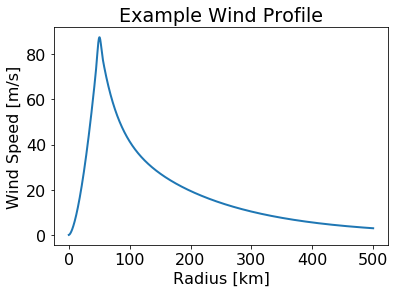

In [33]:
#plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6, 4))
rmax = 50
plt.rcParams.update({'font.size': 16})
profile = W_profile(lati, rmax, wspdi, radius_max, radius_precision)
plt.plot(radius,profile,label=str(np.round(rmax,decimals=1))+' km',linewidth=2)
plt.xlabel('Radius [km]')
plt.ylabel('Wind Speed [m/s]')
plt.title('Example Wind Profile')
plt.savefig('/home/jbaldwin/WorldBank/FIGURES/windprofile.png',dpi=400)


In [50]:
windfield = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_REG/wspd_phi_430.nc').sel(nS=430).sel(iT=61).wspd

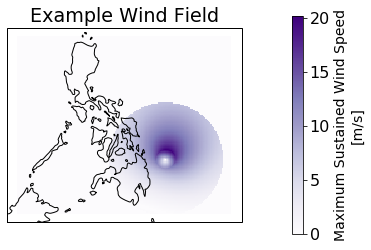

In [72]:
ax = plt.subplot(111,projection=ccrs.PlateCarree())
p = np.abs(windfield).sel(lon=slice(116,133),lat=slice(5,19)).plot(cmap=plt.cm.Purples,transform=ccrs.PlateCarree(),add_colorbar=False)
plt.title('Example Wind Field')
ax.coastlines('50m')
cb = plt.colorbar(p, orientation="vertical", pad=0.15)
cb.set_label(label='Maximum Sustained Wind Speed\n[m/s]',fontsize=14)
plt.savefig('/home/jbaldwin/WorldBank/FIGURES/windfield.png',dpi=400)



In [123]:
ds = xr.Dataset(
     {"wspd": (("nS", "iT","lat", "lon"), wspdmaps),
      "days": (("nS","iT"), np.expand_dims(days_landfall[nS][2:5],axis=0)),
      "year": (("nS"), [year[nS]])},
         coords={
        "nS":np.array([nS]),
        "iT":np.arange(np.shape(wspdmaps)[1]),
        "lat": Y,
        "lon": X,
     },
 )
 

#ds_int = xr.Dataset(
    #{"lon": (("iT","nS"), lon_int_phi),
    # "lat": (("iT","nS"), lat_int_phi),
    # "wspd": (("iT","nS"), wspd_int_phi), # maximum sustained wind speed in m/s
    # "days": (("iT","nS"), days_int_phi),
    # "year": (("nS"), year_phi)},
    #    coords={
    #    "iT": np.arange(np.shape(lon_int_phi)[0]),
    #    "nS": np.arange(np.shape(lon_int_phi)[1]),
    # },
# )    

ds.to_netcdf("wspd_phi_test2.nc",unlimited_dims = ["nS","iT"])


In [5]:
test = np.max(xr.open_dataset('/data2/jbaldwin/WINDFIELDS/PHI_REG/wspd_phi_5.nc').wspd,axis=1)
lon = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/PHI_REG/wspd_phi_5.nc').lon
lat = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/PHI_REG/wspd_phi_5.nc').lat


Text(0.5, 1.0, 'IBTrACS Typhoons Making Landfall in the Philippines')

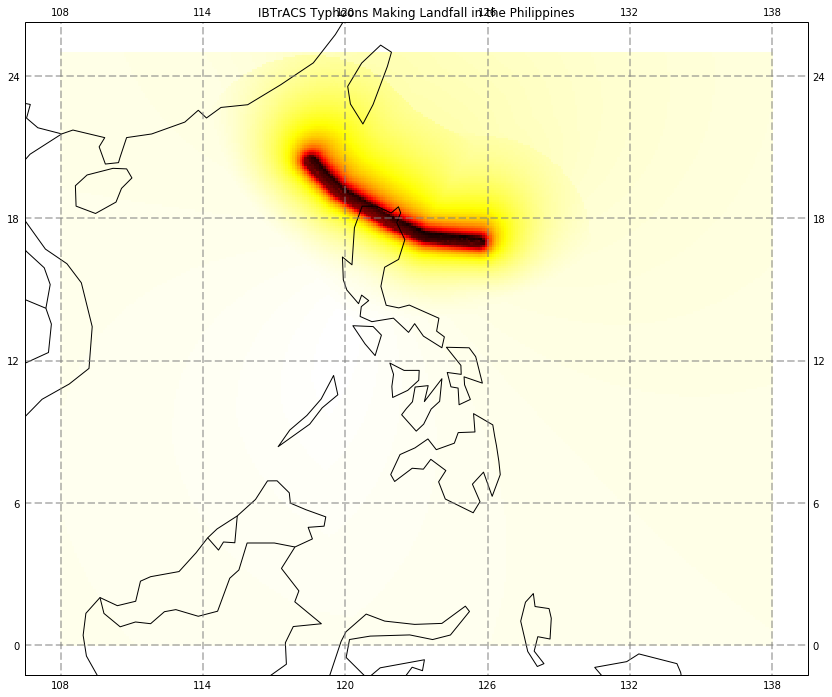

In [8]:
# Plotting tracks 1 day before and after landfall
nS = 5

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon,lat,test[0],cmap=plt.cm.hot_r)
#plt.scatter(lon_landfall[nS],lat_landfall[nS],c=np.arange(0,len(lon_landfall[nS]),1),cmap=plt.cm.Greys)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')


#ax.set_extent([lonmin-10,lonmax+10,latmin-10,latmax+10])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('IBTrACS Typhoons Making Landfall in the Philippines')

 # CODE SCRAPS FOR LATER

In [168]:
%%time

wspdmaps = []
# Calculate and collect wind fields
# Determine Willoughby Profile
#stormpoints = np.where(np.isnan(wspd))[0][0]
stormpoints = np.shape(wspd_test)[0]
for i in range(stormpoints):
    loni = lon_test[i]
    lati = lat_test[i]
    wspdi = wspd_test[i]
    rmaxi = rmax[i]
    
    # Calculate Willougby Profile
    radius_max = 500
    radius_precision = 1
    profile = W_profile(lati, rmaxi, wspdi, radius_max, radius_precision)
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    
    # Create dict look-up table from Willoughby Profile
    wspdlookup = dict(zip(radius, profile))
    
    # Calculate distance from center of storm
    distance = distancefrompoint(loni, lati, X1, Y1)
    
    # Round distance values to nearest whole number
    distance = distance.astype(int)

    # Remap radii to windspeed
    wspdmap = np.zeros(np.shape(distance))
    for r in radius:
        wspdmap[np.where(distance == r)] = wspdlookup[r]
    wspdmaps.append(wspdmap)
    
    # To assess progress in running
    print(i)

0
1
2
3
4
5
6
7
CPU times: user 2min 22s, sys: 1.72 s, total: 2min 24s
Wall time: 1min 28s


Text(0.5, 1.0, 'Typhoon Haiyan Wind Field, 11/8/13 Noon')

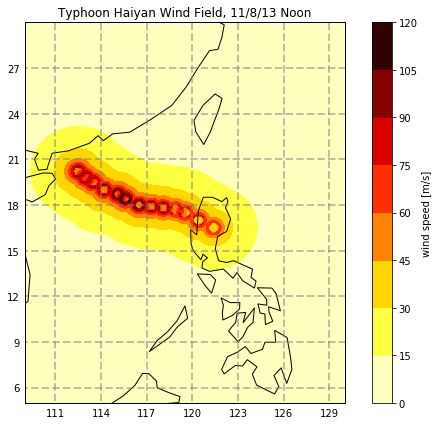

In [114]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

p1 = plt.contourf(X1,Y1,np.max(wspdmaps,axis=0),cmap=plt.cm.hot_r)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.set_extent([109, 130, 5, 30])
cbar = plt.colorbar(p1)
cbar.set_label('wind speed [m/s]', rotation=90)

plt.title('Typhoon Haiyan Wind Field, 11/8/13 Noon')

In [62]:
# RETRIEVE WNP STORM INFORMATION
fileName = '/data2/clee/bttracks/Allstorms.ibtracs_all.v03r10.nc'
ibtracs = readbst.read_ibtracs(fileName, 'wnp')
ipoi = np.array([1925]) # index for storm Haiyan is 1925

# Load data from file
lon = ibtracs.lon[:, ipoi]
lat = ibtracs.lat[:, ipoi]
wspd = ibtracs.wspd[:, ipoi] # wind speed in knots
days = ibtracs.days[:, ipoi] # date in days
dist2land = ibtracs.dist2land[:, ipoi]
year = ibtracs.year[ipoi]


[10] wnp
(2071,)


In [85]:
# WILL NEED FOR ADDING BACK IN THE WIND FIELD ASYMMETRY LATER
# Derive some additional quantities from data
#tt = np.empty(wspd.shape, dtype=object)
#count = 0
#for i in range(ipoi.shape[0]):
 #   for j in range(wspd.shape[0]):
  #      if days[j, i] == days[j, i]:
   #         tt[j, count] = datetime.datetime(
    #            1858, 11, 17, 0, 0)+datetime.timedelta(days=days[j, i])
    #count += 1
#lon_diff = lon[1:, :]-lon[0:-1, :]
#lat_diff = lat[1:, :]-lat[0:-1, :]
#londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # 1 degree longitude in km at given latitude
#dx = londis*lon_diff # longitude difference in km
#dy = 110.*lat_diff # latitude difference in km
#days_diff = (days[1:, :] - days[0:-1, :])*24. # days --> hours
#tr = old_div(np.sqrt(dx**2+dy**2),(days_diff)) # track translation speed, km/hr
#trDir = np.arctan2(lat_diff, lon_diff)
